# Project 4: Predicting outbreaks caused by West Nile Virus and using cost benefit analysis to help the City of Chicago.

Done by: Richelle-Joy Chia, Er Jie Yong, Meriky Lo 

Problem Statement: How can we help the City of Chicago Public Health Department accurately predict outbreaks and optimize measures to tackle financial burdens caused by WNV related diseases?

## Part 2a: Preprocessing and Modeling

### Importing packages and datasets

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'. We supress the pandas warning on SettingWithCopyWarning 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopy.distance
import scipy.stats as stats
import os

#to allow for progress tracking
from tqdm import tqdm
tqdm.pandas()

from pycaret.classification import *

C:\Users\kyuno\anaconda3\envs\dsi-p4\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\kyuno\anaconda3\envs\dsi-p4\lib\site-packages\numpy\.libs\libopenblas.gk7gx5keq4f6uyo3p26ulgbqyhgqo7j4.gfortran-win_amd64.dll
C:\Users\kyuno\anaconda3\envs\dsi-p4\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# set up mlflow
import mlflow 
mlflow.set_tracking_uri("sqlite:///mlflow.db") 
mlflow.set_experiment("GA-dsi32-project-4") 

<Experiment: artifact_location='./mlruns/2', creation_time=1666755814391, experiment_id='2', last_update_time=1666755814391, lifecycle_stage='active', name='GA-dsi32-project-4', tags={}>

In [3]:
df_train_combined = pd.read_csv('./assets/df_train_combined.csv')
df_test_combined = pd.read_csv('./assets/df_test_combined.csv')

In [4]:
cols_to_drop = [
    'New_ID',
    'Tmax',
    'Tmin',
    'Heat',
    'Cool', 
    'Sunrise',
    'Sunset',
    'Tdiff',
    'ResultSpeed',
    'ResultDir',
]

In [5]:
df_train_combined.drop(cols_to_drop, axis = 1, inplace = True)
df_test_combined.drop(cols_to_drop, axis = 1, inplace = True)

In [6]:
categorical_features = ['Trap', 'Station', 'species_no']
date_features = ['Date']
ignore_features = ['Species', 'neigh_mosq_sum', 'NumMosquitos', 'Tavg', 'WetBulb', 'PrecipTotal', 'AvgSpeed', 'Humidity', 'SunMins', 'Year','Month','Day','WetDry','trap_sprayed']

In [7]:
# Saving predicted value for models
def predict_save(model, filename):
    save_model(model, filename)
    loaded_model = load_model(filename)
    df_submit = pd.DataFrame(zip(list(df_test_combined['Id']), [one for zero, one in loaded_model.predict_proba(df_test_combined.drop('Id', axis = 1))]),columns = ['Id','WnvPresent'])
    df_submit.to_csv(path_or_buf = './models/'+filename+'.csv', index=False)
    print(f"{filename}.csv has been saved in {os.getcwd()}")
    return df_submit

### Preprocessing steps

Stage 1
- StandardScaler (normalize), PolynomialFeatures(polynomial_features), SelectKBest (feature_selection), remove_multicollinearity
- PowerTransformer (transformation), PolynomialFeatures(polynomial_features), SelectKBest (feature_selection), remove_multicollinearity
- StandardScaler (normalize), PolynomialFeatures(polynomial_features), PCA (pca), remove_multicollinearity
- PowerTransformer (transformation), PolynomialFeatures(polynomial_features), PCA (pca), remove_multicollinearity

Stage 2 (Further tweaking)
We will use the best model and perform a/b testing for the following hyperparameters to try and get the best result
- clustering (create_clusters)
- remove_outliers (remove_outliers)
- remove polynomial features

# S0 Model
Baseline Model

In [8]:
# Baseline model
s0 = setup(df_train_combined,
           target = 'WnvPresent',
           use_gpu = True,
           categorical_features = categorical_features,
           ignore_features = ignore_features,
           data_split_shuffle = False,
           fix_imbalance = True,
           silent = True,
           session_id = 42,
          )

,Description,Value
0,session_id,42
1,Target,WnvPresent
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(8475, 33)"
5,Missing Values,True
6,Numeric Features,14
7,Categorical Features,3
8,Ordinal Features,False
9,High Cardinality Features,False


In [9]:
%%time
s0_model = compare_models(sort = 'AUC')
print(s0_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.6863,0.7508,0.6516,0.1537,0.2075,0.1527,0.2009,0.3460
lr,Logistic Regression,0.6664,0.7415,0.6524,0.2400,0.2218,0.1717,0.2278,1.4780
gbc,Gradient Boosting Classifier,0.7079,0.6887,0.2986,0.3242,0.1056,0.0556,0.0872,3.2710
nb,Naive Bayes,0.5116,0.6301,0.7406,0.0613,0.1119,0.0423,0.1001,0.0680
qda,Quadratic Discriminant Analysis,0.5079,0.6296,0.7616,0.0687,0.1225,0.0538,0.1125,0.2240
ada,Ada Boost Classifier,0.6923,0.6213,0.4375,0.2672,0.1512,0.1014,0.1455,0.8750
lightgbm,Light Gradient Boosting Machine,0.7097,0.5602,0.1757,0.1207,0.0414,-0.0074,-0.0156,0.8720
dummy,Dummy Classifier,0.9606,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0440
dt,Decision Tree Classifier,0.6836,0.4318,0.1583,0.1480,0.0486,-0.0035,-0.0204,0.2120
knn,K Neighbors Classifier,0.4651,0.3879,0.3437,0.1425,0.1417,0.0817,-0.0337,0.7250


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)
CPU times: total: 2min 14s
Wall time: 1min 44s


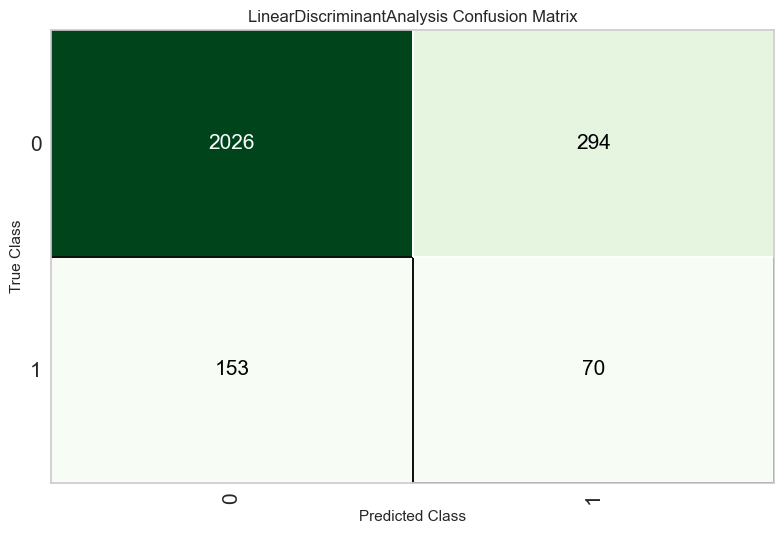

In [10]:
plot_model(s0_model, plot = 'confusion_matrix')

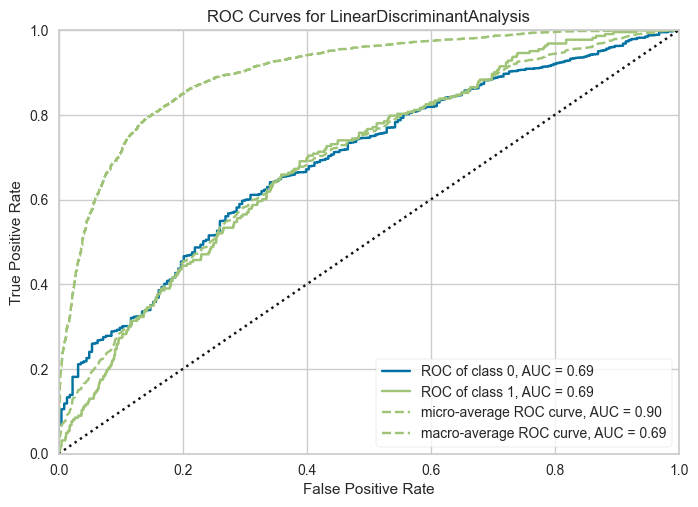

In [11]:
plot_model(s0_model, plot = 'auc')

In [12]:
predict_save(s0_model,'s0_model')

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded
s0_model.csv has been saved in C:\Users\kyunomi\Documents\GA\project4 (1)


,Id,WnvPresent
0,1,0.474616
1,2,0.224916
2,3,0.474525
3,4,0.082804
4,5,0.082804
...,...,...
116288,116289,0.000893
116289,116290,0.000893
116290,116291,0.000893
116291,116292,0.000445


# S1 Model
StandardScaler (normalize), PolynomialFeatures(polynomial_features), SelectKBest (feature_selection), remove_multicollinearity

In [13]:
# StandardScaler (normalize), PolynomialFeatures(polynomial_features), SelectKBest (feature_selection), remove_multicollinearity
s1 = setup(df_train_combined,
           target = 'WnvPresent',
           use_gpu = True,
           categorical_features = categorical_features,
           ignore_features = ignore_features,
           data_split_shuffle = False,
           normalize = True,
           polynomial_features = True,
           feature_selection = True,
           remove_multicollinearity = True,
           fix_imbalance = True,
           silent = True,
           session_id = 42,
          )

,Description,Value
0,session_id,42
1,Target,WnvPresent
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(8475, 33)"
5,Missing Values,True
6,Numeric Features,14
7,Categorical Features,3
8,Ordinal Features,False
9,High Cardinality Features,False


In [14]:
%%time
s1_model = compare_models(sort = 'AUC')
print(s1_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6982,0.7374,0.5835,0.2019,0.2197,0.1671,0.2022,0.2980
lda,Linear Discriminant Analysis,0.6837,0.7312,0.6136,0.1353,0.1895,0.1335,0.1750,0.2610
gbc,Gradient Boosting Classifier,0.6569,0.6823,0.3632,0.2282,0.1001,0.0494,0.0708,2.6470
ada,Ada Boost Classifier,0.6640,0.6590,0.4500,0.2982,0.1723,0.1205,0.1597,0.7220
nb,Naive Bayes,0.4105,0.5916,0.7788,0.0528,0.0982,0.0264,0.0745,0.0550
qda,Quadratic Discriminant Analysis,0.3926,0.5818,0.7871,0.0509,0.0953,0.0230,0.0688,0.1980
lightgbm,Light Gradient Boosting Machine,0.6927,0.5651,0.2219,0.1220,0.0464,-0.0030,-0.0070,0.8450
dummy,Dummy Classifier,0.9606,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0380
knn,K Neighbors Classifier,0.5794,0.4218,0.2607,0.0487,0.0605,-0.0017,-0.0443,0.7070
dt,Decision Tree Classifier,0.6043,0.4106,0.2002,0.1164,0.0460,-0.0148,-0.0506,0.1570


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
CPU times: total: 1min 55s
Wall time: 1min 17s


In [15]:
evaluate_model(s1_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

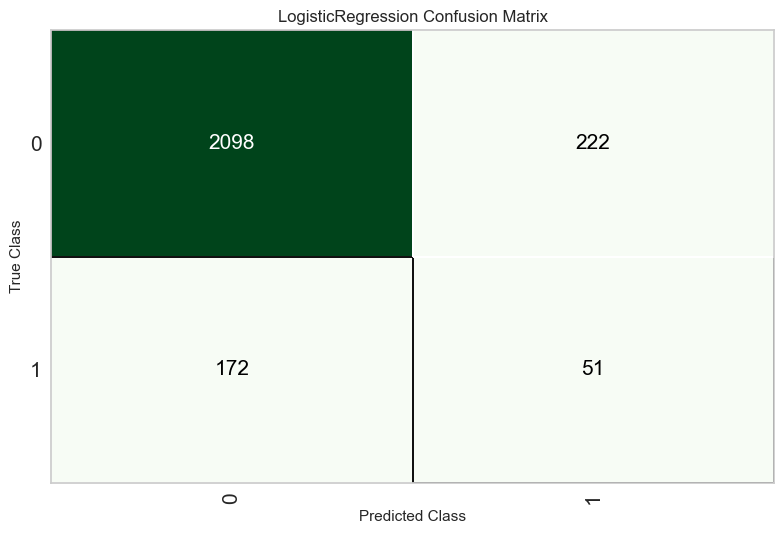

In [16]:
plot_model(s1_model, plot = 'confusion_matrix')

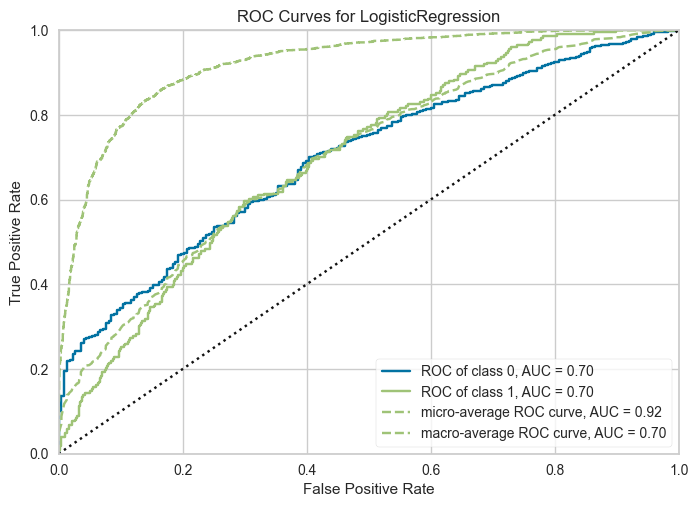

In [17]:
plot_model(s1_model, plot = 'auc')

In [18]:
predict_save(s1_model,'s1_model')

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded
s1_model.csv has been saved in C:\Users\kyunomi\Documents\GA\project4 (1)


,Id,WnvPresent
0,1,0.016633
1,2,0.005634
2,3,0.016633
3,4,0.000096
4,5,0.000096
...,...,...
116288,116289,0.000039
116289,116290,0.000039
116290,116291,0.000039
116291,116292,0.000038


# S2 Model
PowerTransformer (transformation), PolynomialFeatures(polynomial_features), SelectKBest (feature_selection), remove_multicollinearity

In [13]:
s2 = setup(df_train_combined,
           target = 'WnvPresent',
           use_gpu = True,
           categorical_features = categorical_features,
           ignore_features = ignore_features,
           data_split_shuffle = False,
           transformation = True,
           polynomial_features = True,
           feature_selection = True,
           remove_multicollinearity = True,
           fix_imbalance = True,
           log_experiment = True,
           experiment_name = 'GA-dsi32-project-4',
           silent = True,
           session_id = 42,
          )

,Description,Value
0,session_id,42
1,Target,WnvPresent
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(8475, 33)"
5,Missing Values,True
6,Numeric Features,14
7,Categorical Features,3
8,Ordinal Features,False
9,High Cardinality Features,False


In [14]:
%%time
s2_model = compare_models(sort = 'AUC')
print(s2_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6971,0.7626,0.5913,0.3154,0.2375,0.1876,0.2428,0.3080
lda,Linear Discriminant Analysis,0.6765,0.7567,0.6471,0.1738,0.2176,0.1636,0.2072,0.2440
gbc,Gradient Boosting Classifier,0.6558,0.6816,0.3926,0.3313,0.1090,0.0582,0.1052,2.7390
ada,Ada Boost Classifier,0.6544,0.6413,0.4493,0.3136,0.1853,0.1340,0.1663,0.7440
nb,Naive Bayes,0.4004,0.5835,0.7665,0.0538,0.0986,0.0272,0.0679,0.0560
qda,Quadratic Discriminant Analysis,0.3748,0.5746,0.7915,0.0500,0.0937,0.0212,0.0631,0.1820
lightgbm,Light Gradient Boosting Machine,0.6891,0.5483,0.2053,0.1203,0.0431,-0.0066,-0.0146,0.8200
dummy,Dummy Classifier,0.9606,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0370
dt,Decision Tree Classifier,0.6099,0.4136,0.2004,0.0807,0.0511,-0.0040,-0.0514,0.1540
knn,K Neighbors Classifier,0.5580,0.4115,0.2473,0.0944,0.0656,0.0068,-0.0406,0.7190


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
CPU times: total: 1min 46s
Wall time: 1min 22s


In [15]:
evaluate_model(s2_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

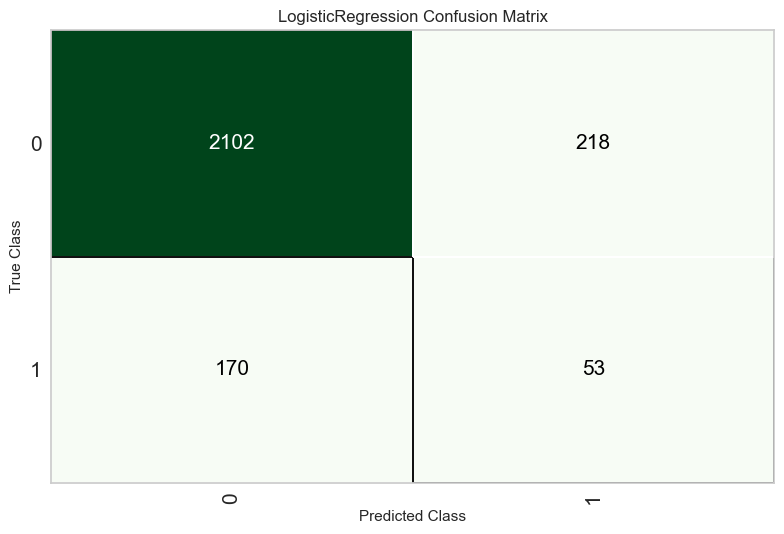

In [22]:
plot_model(s2_model, plot = 'confusion_matrix')

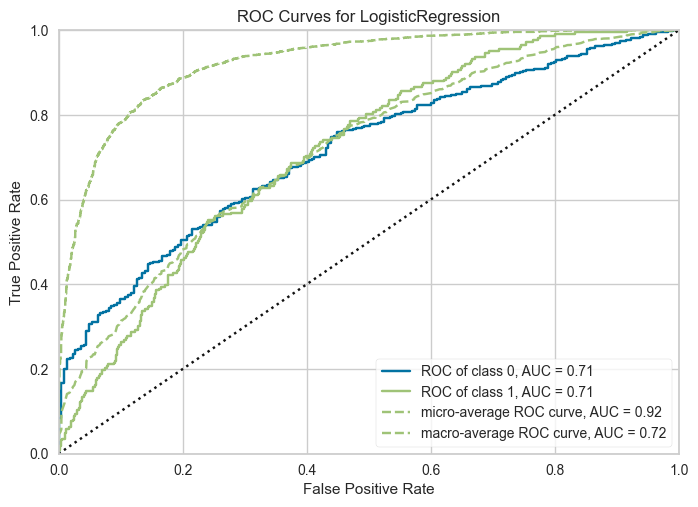

In [23]:
plot_model(s2_model, plot = 'auc')

In [24]:
predict_save(s2_model,'s2_model')

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded
s2_model.csv has been saved in C:\Users\kyunomi\Documents\GA\project4 (1)


,Id,WnvPresent
0,1,0.007263
1,2,0.002102
2,3,0.007263
3,4,0.000056
4,5,0.000056
...,...,...
116288,116289,0.000030
116289,116290,0.000030
116290,116291,0.000030
116291,116292,0.000024


# S3 Model
StandardScaler (normalize), PolynomialFeatures(polynomial_features), PCA (pca), remove_multicollinearity

In [25]:
s3 = setup(df_train_combined,
           target = 'WnvPresent',
           use_gpu = True,
           categorical_features = categorical_features,
           ignore_features = ignore_features,
           data_split_shuffle = False,
           normalize = True,
           polynomial_features = True,
           pca = True,
           remove_multicollinearity = True,
           fix_imbalance = True,
           log_experiment = True,
           experiment_name = 'GA-dsi32-project-4',
           silent = True,
           session_id = 42,
          )

,Description,Value
0,session_id,42
1,Target,WnvPresent
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(8475, 33)"
5,Missing Values,True
6,Numeric Features,14
7,Categorical Features,3
8,Ordinal Features,False
9,High Cardinality Features,False


In [26]:
%%time
s3_model = compare_models(sort = 'AUC')
print(s3_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.6681,0.7456,0.6873,0.1445,0.2050,0.1497,0.2018,0.1370
lr,Logistic Regression,0.6866,0.7409,0.6264,0.2035,0.2235,0.1709,0.2139,0.2220
qda,Quadratic Discriminant Analysis,0.6826,0.6629,0.5525,0.0826,0.1379,0.0748,0.1156,0.1080
ada,Ada Boost Classifier,0.7198,0.6453,0.4370,0.2019,0.1740,0.1216,0.1485,4.1620
nb,Naive Bayes,0.5589,0.6361,0.6042,0.0554,0.1010,0.0310,0.0649,0.0480
gbc,Gradient Boosting Classifier,0.7138,0.6288,0.3600,0.2463,0.1505,0.0995,0.1242,20.7160
lightgbm,Light Gradient Boosting Machine,0.7797,0.5988,0.2067,0.1600,0.0836,0.0410,0.0536,0.8280
rf,Random Forest Classifier,0.8437,0.5047,0.1167,0.1376,0.0580,0.0256,0.0320,1.3570
dummy,Dummy Classifier,0.9606,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0260
dt,Decision Tree Classifier,0.7648,0.4865,0.1842,0.0762,0.0688,0.0159,0.0091,1.2280


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)
CPU times: total: 5min 22s
Wall time: 5min 7s


In [27]:
evaluate_model(s3_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

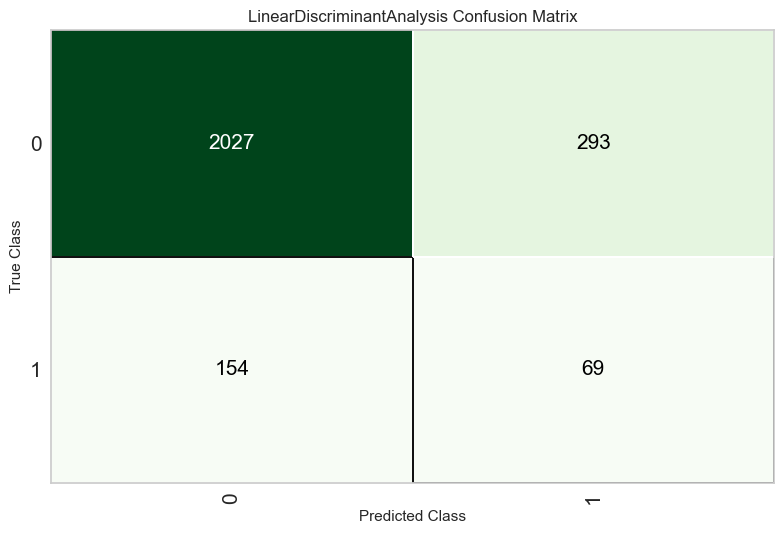

In [28]:
plot_model(s3_model, plot = 'confusion_matrix')

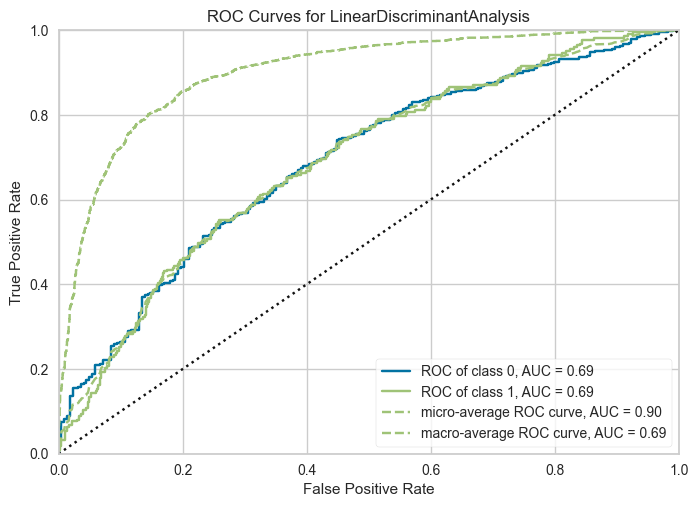

In [29]:
plot_model(s3_model, plot = 'auc')

In [30]:
predict_save(s3_model,'s3_model')

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded
s3_model.csv has been saved in C:\Users\kyunomi\Documents\GA\project4 (1)


,Id,WnvPresent
0,1,0.513769
1,2,0.263375
2,3,0.513769
3,4,0.077376
4,5,0.077376
...,...,...
116288,116289,0.002348
116289,116290,0.002348
116290,116291,0.002348
116291,116292,0.002100


# S4 Model
PowerTransformer (transformation), PolynomialFeatures(polynomial_features), PCA (pca), remove_multicollinearity

In [31]:
# PowerTransformer (transformation), PolynomialFeatures(polynomial_features), PCA (pca), remove_multicollinearity
s4 = setup(df_train_combined,
           target = 'WnvPresent',
           use_gpu = True,
           categorical_features = categorical_features,
           ignore_features = ignore_features,
           data_split_shuffle = False,
           transformation = True,
           polynomial_features = True,
           pca = True,
           remove_multicollinearity = True,
           fix_imbalance = True,
           log_experiment = True,
           experiment_name = 'GA-dsi32-project-4',
           silent = True,
           session_id = 42,
          )

,Description,Value
0,session_id,42
1,Target,WnvPresent
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(8475, 33)"
5,Missing Values,True
6,Numeric Features,14
7,Categorical Features,3
8,Ordinal Features,False
9,High Cardinality Features,False


In [32]:
%%time
s4_model = compare_models(sort = 'AUC')
print(s4_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.6544,0.7704,0.6991,0.2120,0.2380,0.1857,0.2353,0.1390
lr,Logistic Regression,0.6839,0.7691,0.6259,0.3045,0.2446,0.1946,0.2507,0.1830
ada,Ada Boost Classifier,0.7043,0.7279,0.5400,0.2542,0.2335,0.1829,0.2156,4.1450
qda,Quadratic Discriminant Analysis,0.7266,0.6875,0.5611,0.1029,0.1626,0.1034,0.1491,0.0980
gbc,Gradient Boosting Classifier,0.7062,0.6471,0.3810,0.2376,0.1581,0.1064,0.1303,20.6490
lightgbm,Light Gradient Boosting Machine,0.7733,0.6350,0.2101,0.1898,0.0887,0.0463,0.0614,0.8390
nb,Naive Bayes,0.5732,0.6241,0.5654,0.0546,0.0989,0.0291,0.0571,0.0380
dummy,Dummy Classifier,0.9606,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0260
rf,Random Forest Classifier,0.8522,0.4990,0.1371,0.2577,0.0763,0.0436,0.0697,1.3560
dt,Decision Tree Classifier,0.7476,0.4939,0.2183,0.0659,0.0688,0.0160,0.0121,1.4980


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)
CPU times: total: 5min 27s
Wall time: 5min 9s


In [33]:
evaluate_model(s4_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

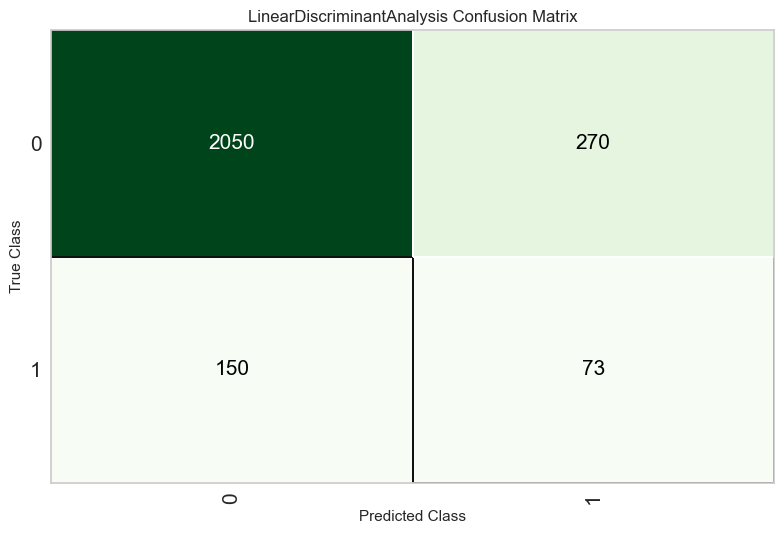

In [34]:
plot_model(s4_model, plot = 'confusion_matrix')

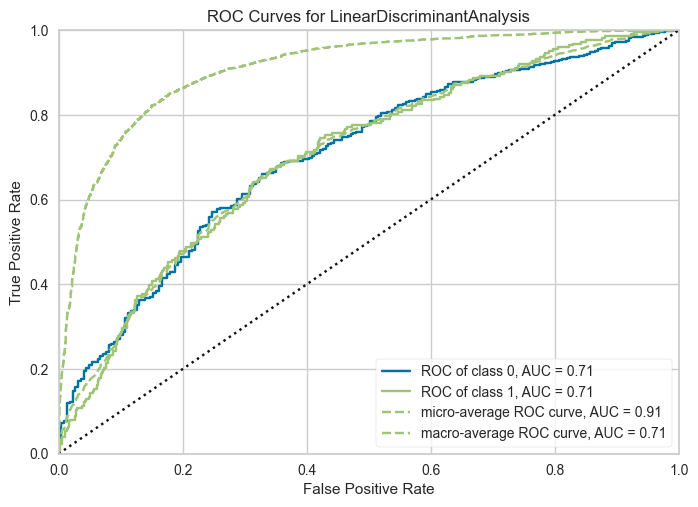

In [35]:
plot_model(s4_model, plot = 'auc')

In [36]:
predict_save(s4_model,'s4_model')

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded
s4_model.csv has been saved in C:\Users\kyunomi\Documents\GA\project4 (1)


,Id,WnvPresent
0,1,0.516720
1,2,0.226413
2,3,0.516720
3,4,0.116289
4,5,0.116289
...,...,...
116288,116289,0.002834
116289,116290,0.002834
116290,116291,0.002834
116291,116292,0.001560


# S5 Model <-- S4
PowerTransformer (transformation), PolynomialFeatures(polynomial_features), PCA (pca), remove_multicollinearity, create_clusters

In [37]:
# PowerTransformer (transformation), PolynomialFeatures(polynomial_features), PCA (pca), remove_multicollinearity
s5 = setup(df_train_combined,
           target = 'WnvPresent',
           use_gpu = True,
           categorical_features = categorical_features,
           ignore_features = ignore_features,
           data_split_shuffle = False,
           transformation = True,
           polynomial_features = True,
           pca = True,
           remove_multicollinearity = True,
           create_clusters = True,
           cluster_iter = 3,
           fix_imbalance = True,
           log_experiment = True,
           experiment_name = 'GA-dsi32-project-4',
           silent = True,
           session_id = 42,
          )

,Description,Value
0,session_id,42
1,Target,WnvPresent
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(8475, 33)"
5,Missing Values,True
6,Numeric Features,14
7,Categorical Features,3
8,Ordinal Features,False
9,High Cardinality Features,False


In [38]:
%%time
s5_model = compare_models(sort = 'AUC')
print(s5_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6740,0.7611,0.6299,0.3452,0.2411,0.1913,0.2553,0.1800
lda,Linear Discriminant Analysis,0.6519,0.7460,0.6906,0.2059,0.2333,0.1806,0.2285,0.1430
gbc,Gradient Boosting Classifier,0.7160,0.6963,0.4321,0.2931,0.1646,0.1167,0.1641,21.2560
ada,Ada Boost Classifier,0.6962,0.6798,0.4928,0.2340,0.1745,0.1262,0.1676,4.2480
qda,Quadratic Discriminant Analysis,0.7591,0.6486,0.4931,0.2189,0.2028,0.1523,0.1917,0.0970
nb,Naive Bayes,0.6064,0.6307,0.5346,0.0562,0.1010,0.0320,0.0600,0.0370
lightgbm,Light Gradient Boosting Machine,0.7598,0.6287,0.2143,0.1118,0.0771,0.0334,0.0352,0.8380
dummy,Dummy Classifier,0.9606,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0260
dt,Decision Tree Classifier,0.7559,0.4960,0.2138,0.0693,0.0714,0.0186,0.0142,1.3440
rf,Random Forest Classifier,0.8340,0.4957,0.1380,0.1303,0.0600,0.0266,0.0357,1.2820


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
CPU times: total: 5min 30s
Wall time: 5min 13s


In [39]:
evaluate_model(s5_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

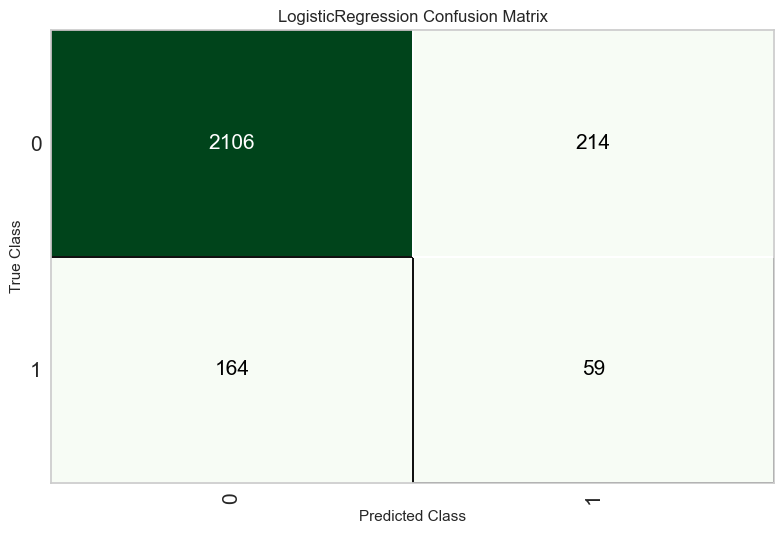

In [40]:
plot_model(s5_model, plot = 'confusion_matrix')

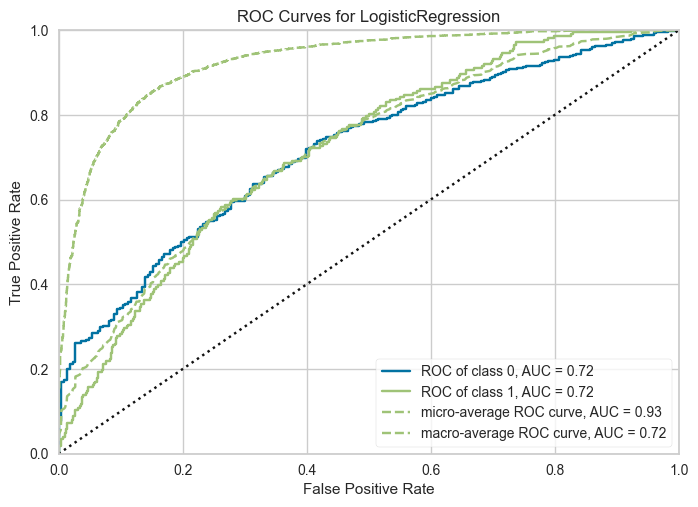

In [41]:
plot_model(s5_model, plot = 'auc')

In [42]:
predict_save(s5_model,'s5_model')

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded
s5_model.csv has been saved in C:\Users\kyunomi\Documents\GA\project4 (1)


,Id,WnvPresent
0,1,0.003115
1,2,0.000779
2,3,0.003115
3,4,0.000023
4,5,0.000023
...,...,...
116288,116289,0.000014
116289,116290,0.000014
116290,116291,0.000014
116291,116292,0.000012


# S6 Model <-- S4
PowerTransformer (transformation), PolynomialFeatures(polynomial_features), PCA (pca), remove_multicollinearity, remove_outliers

In [ ]:
# remove outliers
s6 = setup(df_train_combined,
           target = 'WnvPresent',
           use_gpu = True,
           categorical_features = categorical_features,
           ignore_features = ignore_features,
           data_split_shuffle = False,
           transformation = True,
           remove_outliers = True,
           pca = True,
           fix_imbalance = True,
           log_experiment = True,
           experiment_name = 'GA-dsi32-project-4',
           silent = True,
           session_id = 42,
          )

In [44]:
%%time
s6_model = compare_models(sort = 'AUC')
print(s6_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lda,Linear Discriminant Analysis,0.6500,0.7769,0.6990,0.1645,0.2187,0.1644,0.2122,0.1590
lr,Logistic Regression,0.6644,0.7731,0.6638,0.3174,0.2519,0.2024,0.2609,0.2000
qda,Quadratic Discriminant Analysis,0.7827,0.7147,0.5717,0.2655,0.2603,0.2113,0.2604,0.1130
nb,Naive Bayes,0.6593,0.7029,0.6144,0.0803,0.1398,0.0733,0.1232,0.0420
ada,Ada Boost Classifier,0.7163,0.6972,0.5198,0.2567,0.2313,0.1828,0.2109,4.4950
gbc,Gradient Boosting Classifier,0.6983,0.6535,0.3688,0.1875,0.1398,0.0897,0.1017,22.4060
lightgbm,Light Gradient Boosting Machine,0.7602,0.5948,0.2451,0.2414,0.1020,0.0583,0.0789,0.8710
dt,Decision Tree Classifier,0.7546,0.5189,0.2625,0.0937,0.0855,0.0315,0.0427,1.5990
dummy,Dummy Classifier,0.9595,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0280
rf,Random Forest Classifier,0.8551,0.4607,0.1449,0.1500,0.0878,0.0535,0.0629,1.2960


LinearDiscriminantAnalysis(n_components=None, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)
CPU times: total: 5min 52s
Wall time: 5min 30s


In [45]:
evaluate_model(s6_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

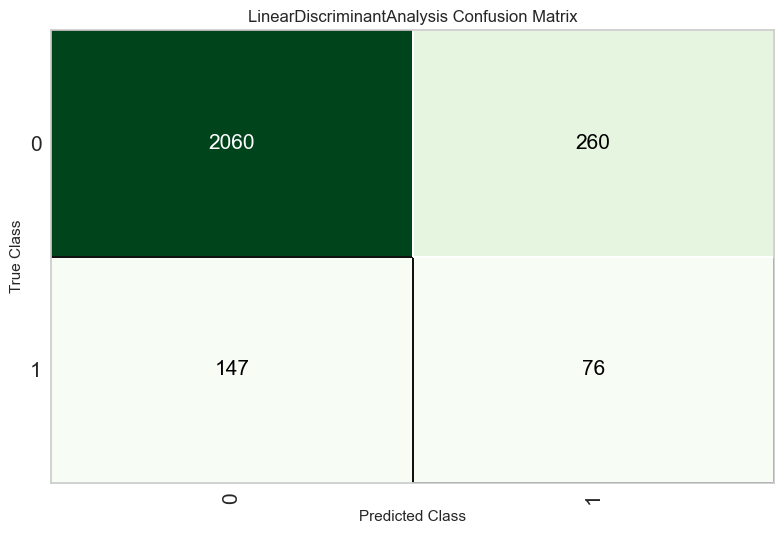

In [46]:
plot_model(s6_model, plot = 'confusion_matrix')

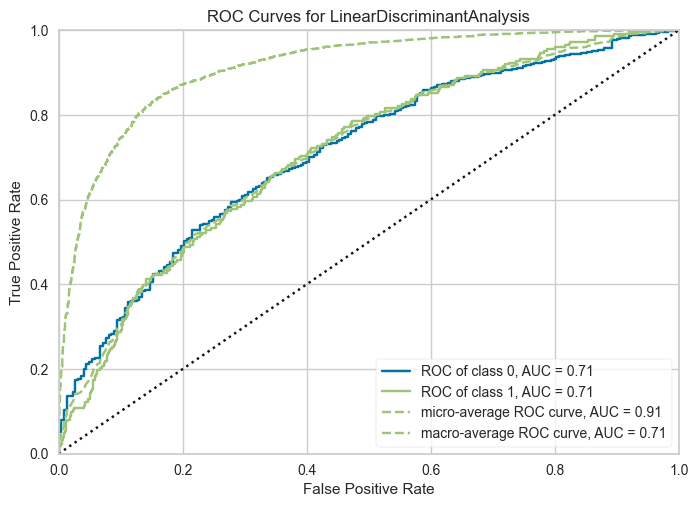

In [47]:
plot_model(s6_model, plot = 'auc')

In [48]:
predict_save(s6_model,'s6_model')

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded
s6_model.csv has been saved in C:\Users\kyunomi\Documents\GA\project4 (1)


,Id,WnvPresent
0,1,0.659034
1,2,0.313202
2,3,0.658821
3,4,0.286255
4,5,0.286255
...,...,...
116288,116289,0.002071
116289,116290,0.002071
116290,116291,0.002071
116291,116292,0.000487


# S7 Model <-- S4
PowerTransformer (transformation), PCA (pca), remove_multicollinearity

In [8]:
import imblearn
s7 = setup(df_train_combined,
           target = 'WnvPresent',
           use_gpu = True,
           categorical_features = categorical_features,
           date_features = date_features,
           ignore_features = ignore_features,
           data_split_shuffle = False,
           #normalize = True,
           transformation = True,
           # polynomial_features = True,
           pca = True,
           remove_multicollinearity = True,
           #remove_outliers = True,
           fix_imbalance = True,
           #fix_imbalance_method = imblearn.over_sampling.ADASYN(),
           # create_clusters = True,
           # cluster_iter = 5,
           log_experiment = True,
           experiment_name = 'GA-dsi32-project-4',
           silent = True,
           session_id = 42,
          )

,Description,Value
0,session_id,42
1,Target,WnvPresent
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(8475, 33)"
5,Missing Values,True
6,Numeric Features,14
7,Categorical Features,3
8,Ordinal Features,False
9,High Cardinality Features,False


In [9]:
%%time
s7_model = compare_models(sort = 'AUC')
print(s7_model)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lr,Logistic Regression,0.6837,0.7764,0.6386,0.3258,0.2497,0.2007,0.2598,0.6450
lda,Linear Discriminant Analysis,0.6510,0.7750,0.6900,0.2059,0.2340,0.1820,0.2290,0.3560
ada,Ada Boost Classifier,0.6897,0.7021,0.4321,0.2006,0.1653,0.1109,0.1318,6.8950
qda,Quadratic Discriminant Analysis,0.7303,0.6755,0.5697,0.1348,0.1925,0.1366,0.1765,0.4590
gbc,Gradient Boosting Classifier,0.6991,0.6684,0.4063,0.2760,0.1588,0.1085,0.1446,32.8960
nb,Naive Bayes,0.5971,0.6450,0.5737,0.0611,0.1093,0.0408,0.0733,0.0910
lightgbm,Light Gradient Boosting Machine,0.7662,0.6214,0.2230,0.2827,0.0991,0.0539,0.0804,4.7060
dummy,Dummy Classifier,0.9606,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0650
rf,Random Forest Classifier,0.8345,0.4708,0.1462,0.2415,0.0747,0.0386,0.0610,3.1320
dt,Decision Tree Classifier,0.6869,0.4603,0.2141,0.0747,0.0709,0.0162,-0.0046,2.6630


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
CPU times: total: 9min 13s
Wall time: 9min 26s


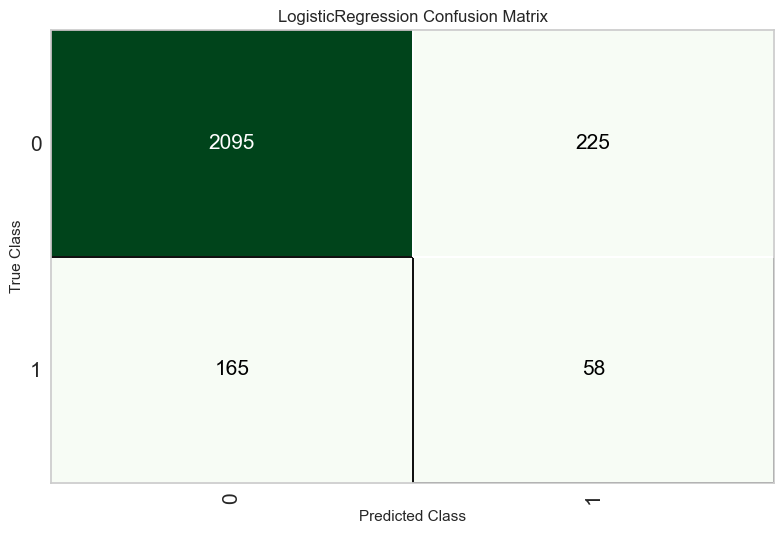

In [10]:
plot_model(s7_model, plot = 'confusion_matrix')

In [11]:
evaluate_model(s7_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Hyperparameters', 'param…

In [12]:
predict_save(s7_model,'s7_model')

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded
s7_model.csv has been saved in C:\Users\kyuno\Documents\GA\my_materials\project_4


,Id,WnvPresent
0,1,0.002606
1,2,0.000674
2,3,0.002605
3,4,0.000030
4,5,0.000030
...,...,...
116288,116289,0.000023
116289,116290,0.000023
116290,116291,0.000023
116291,116292,0.000014


In [13]:
S7_model_tuned = tune_model(s7_model, optimize='AUC', choose_better = True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9663,0.9010,0.1667,1.0000,0.2857,0.2774,0.4013
1,0.4293,0.6980,0.9167,0.0613,0.1149,0.0423,0.1310
2,0.1400,0.6472,1.0000,0.0432,0.0827,0.0090,0.0674
3,0.3642,0.5585,0.7826,0.0462,0.0872,0.0150,0.0529
4,0.8415,0.9304,0.8261,0.1743,0.2879,0.2391,0.3331
5,0.9983,1.0000,0.9565,1.0000,0.9778,0.9769,0.9772
6,0.6914,0.7657,0.7391,0.0876,0.1567,0.0938,0.1764
7,0.7555,0.6521,0.1739,0.0308,0.0523,-0.0146,-0.0220
8,0.9680,0.9069,0.2500,0.8571,0.3871,0.3757,0.4529


In [14]:
S7_model_tuned

LogisticRegression(C=0.431, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [15]:
predict_save(S7_model_tuned,'s7_model_tuned')

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded
s7_model_tuned.csv has been saved in C:\Users\kyuno\Documents\GA\my_materials\project_4


,Id,WnvPresent
0,1,0.005132
1,2,0.001365
2,3,0.005130
3,4,0.000142
4,5,0.000142
...,...,...
116288,116289,0.000131
116289,116290,0.000131
116290,116291,0.000131
116291,116292,0.000076


In [16]:
S7_model_ensemble = ensemble_model(S7_model_tuned, optimize='AUC', choose_better = True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9663,0.9006,0.1667,1.0000,0.2857,0.2774,0.4013
1,0.4209,0.6999,0.9583,0.0628,0.1179,0.0456,0.1444
2,0.1400,0.6395,1.0000,0.0432,0.0827,0.0090,0.0674
3,0.3592,0.5615,0.7826,0.0458,0.0865,0.0143,0.0509
4,0.8398,0.9310,0.8261,0.1727,0.2857,0.2367,0.3310
5,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000,1.0000
6,0.6914,0.7686,0.6957,0.0833,0.1488,0.0855,0.1596
7,0.7605,0.6585,0.1739,0.0315,0.0533,-0.0132,-0.0197
8,0.9680,0.9095,0.2500,0.8571,0.3871,0.3757,0.4529


In [17]:
predict_save(S7_model_ensemble,'S7_model_ensemble')

Transformation Pipeline and Model Successfully Saved
Transformation Pipeline and Model Successfully Loaded
S7_model_ensemble.csv has been saved in C:\Users\kyuno\Documents\GA\my_materials\project_4


,Id,WnvPresent
0,1,0.005635
1,2,0.001424
2,3,0.005633
3,4,0.000173
4,5,0.000173
...,...,...
116288,116289,0.000132
116289,116290,0.000132
116290,116291,0.000132
116291,116292,0.000071


Conclusion: As S7 model produces the best results and obtain the highest kaggle public score of 0.72452 and private score of 0.70854, we will proceed to use S7 for the next phase of modeling

## Let's move on to the other modeling notebook that used weighted matrix (a combination of trap distance and WNV PDF).